In [1171]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from IPython.display import display
from plotly.subplots import make_subplots

pd.options.plotting.backend = "plotly"


def generate_test_data():
    num_users = 20
    num_groups = 3
    num_repeat = 10

    dates = pd.date_range(start="2022-01-01", end="2022-12-31")
    total_num = dates.shape[0] * num_repeat
    usernames = [
        f"user-{num}"
        for num in (np.random.rand(total_num) * num_users).astype(int).tolist()
    ]
    groups = [
        f"group-{num}"
        for num in (np.random.rand(total_num) * num_groups).astype(int).tolist()
    ]

    base_df = (
        pd.concat(
            [pd.DataFrame(dates, columns=["timestamp"]) for _ in range(num_repeat)]
        )
        .reset_index(drop=True)
        .assign(count=1)
    )
    df = base_df.assign(
        username=usernames,
        group=groups,
    )
    return df.drop_duplicates()


def convert_freq(df, freq):
    df["timestamp"] = df["timestamp"].dt.to_period(freq=freq).dt.start_time
    return df.drop_duplicates()


df = generate_test_data()
df = convert_freq(df, "W")
df.head()

,timestamp,count,username,group
0,2021-12-27,1,user-2,group-1
1,2021-12-27,1,user-5,group-1
2,2022-01-03,1,user-14,group-1
3,2022-01-03,1,user-3,group-0
4,2022-01-03,1,user-15,group-2


In [1174]:
def create_matrix(df, add_column):
    return (
        df.reset_index()
        .pivot(index=["username", add_column], columns=["timestamp"], values=["count"])
        .droplevel(axis=1, level=0)
        .fillna(0)
    )


def create_matrix_username_columns(df, add_column):
    return (
        df.reset_index()
        .pivot(index=["timestamp", add_column], columns=["username"], values=["count"])
        .droplevel(axis=1, level=0)
        .fillna(0)
    )


def common_new_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    new_df = (
        matrix_df.idxmax(axis=1)
        .to_frame(name="timestamp")
        .assign(count=1)
        .reset_index()
        .pivot(index=["username", add_column], columns=["timestamp"], values="count")
        .sort_index()
        .fillna(0)
    )
    return new_df


def get_new_user(df, add_column):
    return (
        common_new_user(df, add_column)
        .stack()
        .to_frame(name="count")
        .reset_index()
        .pivot(index=["timestamp", add_column], columns="username", values="count")
        .sum(axis=1)
    )


def get_new_user_mask(df, add_column):
    return common_new_user(df, add_column).cumsum(axis=1).astype(bool)


def get_retained_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    return (
        ((matrix_df - matrix_df.shift(1, axis=1) == 0) & matrix_df.astype(bool))
        .stack()
        .to_frame("count")
        .reset_index()
        .pivot(index=["timestamp", add_column], columns="username", values="count")
        .sum(axis=1)
    )


def get_resurrected_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    shifted_df = matrix_df - matrix_df.shift(1, axis=1) == 1
    not_new_user_df = ~common_new_user(df, add_column).astype(bool)
    left, right = shifted_df.align(not_new_user_df, axis=1, join="outer")
    return (
        (left & right.fillna(True))
        .stack()
        .to_frame("count")
        .reset_index()
        .pivot(index=["timestamp", add_column], columns="username", values="count")
        .sum(axis=1)
    )


def get_churned_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    return (
        ((matrix_df - matrix_df.shift(1, axis=1) == -1) & ~matrix_df.astype(bool))
        .stack()
        .to_frame("count")
        .reset_index()
        .pivot(index=["timestamp", add_column], columns="username", values="count")
        .sum(axis=1)
    )


def get_continuous_churned_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    return (
        ((matrix_df - matrix_df.shift(1, axis=1) == 0) & ~matrix_df.astype(bool))
        .stack()
        .to_frame("count")
        .reset_index()
        .pivot(index=["timestamp", add_column], columns="username", values="count")
        .sum(axis=1)
    )


def get_au1_au2(df, add_column, freq1, freq2):
    return (
        pd.DataFrame(df)
        .reset_index()
        .groupby([pd.Grouper(key="timestamp", freq=freq1), add_column])
        .sum()
        / pd.DataFrame(df)
        .reset_index()
        .groupby([pd.Grouper(key="timestamp", freq=freq2), add_column])
        .sum()
    ).dropna()[["count"]]


COL_GROUP = "group"

# Test
display(create_matrix(df, COL_GROUP).head())
# display(create_matrix_username_columns(df, COL_GROUP).head())
# display(get_new_user_mask(df, COL_GROUP).head())
# display(get_new_user(df, COL_GROUP).head())
# display(get_retained_user(df, COL_GROUP).head())
# display(get_resurrected_user(df, COL_GROUP).head())
# display(get_churned_user(df, COL_GROUP).head())
# display(get_continuous_churned_user(df, COL_GROUP).head())
# display(get_au1_au2(df, COL_GROUP, 'W', '4W').head())

timestamp         2021-12-27  2022-01-03  2022-01-10  2022-01-17  2022-01-24  \
username group                                                                 
user-0   group-0         0.0         1.0         1.0         0.0         1.0   
         group-1         0.0         1.0         1.0         1.0         0.0   
         group-2         0.0         1.0         1.0         1.0         1.0   
user-1   group-0         1.0         1.0         0.0         0.0         1.0   
         group-1         0.0         1.0         1.0         0.0         1.0   

timestamp         2022-01-31  2022-02-07  2022-02-14  2022-02-21  2022-02-28  \
username group                                                                 
user-0   group-0         1.0         1.0         0.0         1.0         1.0   
         group-1         1.0         1.0         1.0         0.0         1.0   
         group-2         1.0         1.0         0.0         0.0         1.0   
user-1   group-0         0.0         0.0         1.0         1.0         0.0   
         group-1         0.0         1.0         0.0         1.0         0.0   

timestamp         ...  2022-10-24  2022-10-31  2022-11-07  2022-11-14  \
username group    ...                                                   
user-0   group-0  ...         1.0         1.0         1.0         1.0   
         group-1  ...         1.0         1.0         1.0         0.0   
         group-2  ...         1.0         0.0         1.0         1.0   
user-1   group-0  ...         1.0         1.0         0.0         1.0   
         group-1  ...         0.0         0.0         1.0         1.0   

timestamp         2022-11-21  2022-11-28  2022-12-05  2022-12-12  2022-12-19  \
username group                                                                 
user-0   group-0         1.0         1.0         0.0         1.0         1.0   
         group-1         1.0         1.0         1.0         1.0         1.0   
         group-2         0.0         1.0         0.0         1.0         0.0   
user-1   group-0         1.0         1.0         1.0         1.0         0.0   
         group-1         1.0         1.0         1.0         1.0         1.0   

timestamp         2022-12-26  
username group                
user-0   group-0         0.0  
         group-1         1.0  
         group-2         0.0  
user-1   group-0         1.0  
         group-1         1.0  

[5 rows x 53 columns]

# Quick Ratio

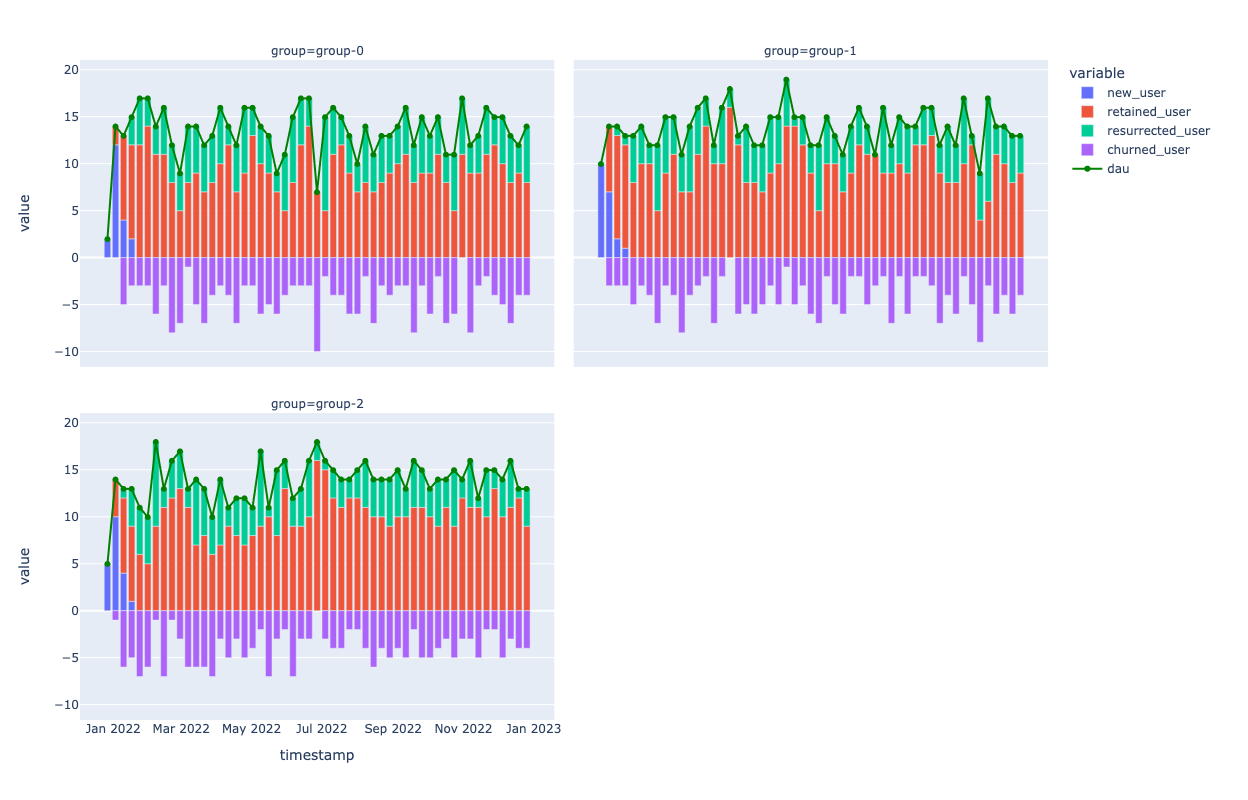

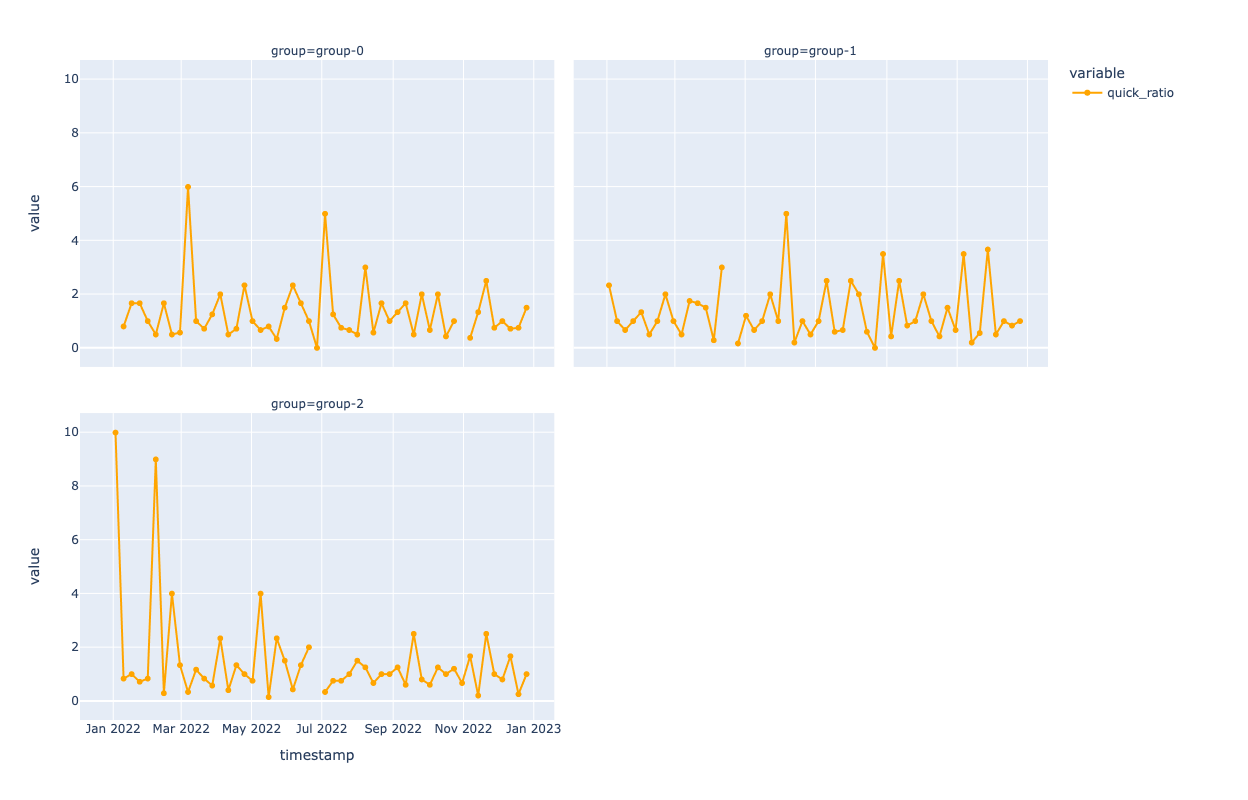

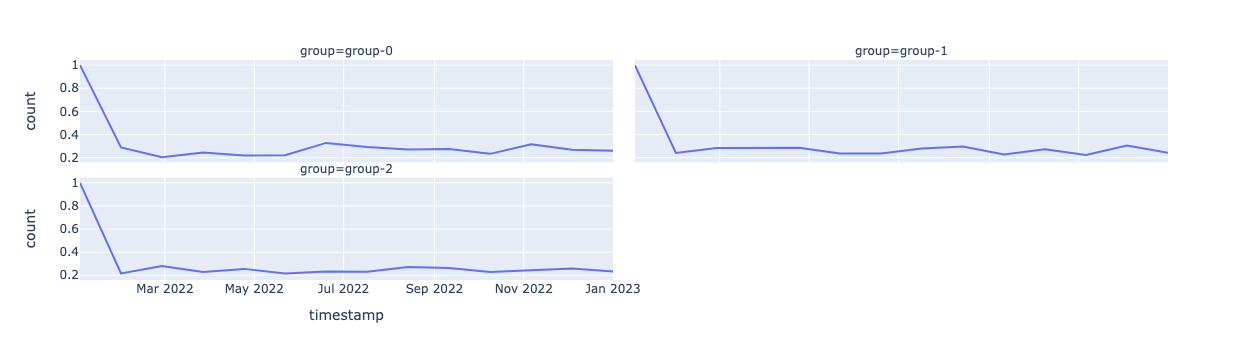

In [1170]:
new = (
    create_matrix_username_columns(df, COL_GROUP)
    .assign(
        dau=create_matrix_username_columns(df, COL_GROUP).sum(axis=1),
        new_user=get_new_user(df, COL_GROUP),
        retained_user=get_retained_user(df, COL_GROUP),
        churned_user=get_churned_user(df, COL_GROUP),
        continuous_churned_user=get_continuous_churned_user(df, COL_GROUP),
        resurrected_user=get_resurrected_user(df, COL_GROUP),
    )
    .fillna(0)
)

new["total"] = (
    new.new_user
    + new.retained_user
    + new.resurrected_user
    + new.churned_user
    + new.continuous_churned_user
)
new["check"] = new.dau == new.new_user + new.retained_user + new.resurrected_user

## Plot
new["quick_ratio"] = (new.new_user + new.resurrected_user) / new.churned_user
new["churned_user"] = -new["churned_user"]
new["continuous_churned_user"] = -new["continuous_churned_user"]
# display(new[new.total != num_users])

# WebGL mode
fig_dau = go.Scattergl(
    x=new.index,
    y=new["dau"],
    name="dau",
    mode="lines+markers",
)

fig_quick_ratio = go.Scattergl(
    x=new.index,
    y=new["quick_ratio"],
    name="quick_ratio",
    mode="lines+markers",
)

facet_col_args = {"facet_col": "group", "facet_col_wrap": 2}
commomn_layout = {
    "width": 1200,
    "height": 800,
    "margin": {"r": 200},
}
fig = (
    px.bar(
        new.reset_index(),
        x="timestamp",
        y=["new_user", "retained_user", "resurrected_user", "churned_user"],
        **facet_col_args
    )
).update_layout(**commomn_layout)
fig_dau = px.line(
    new.reset_index(),
    x="timestamp",
    y=["dau"],
    markers=True,
    render_mode="webgl",
    **facet_col_args
).update_traces(line_color="green")
fig.add_traces(fig_dau.data)
fig.show()

fig_quick_ratio = (
    px.line(
        new.reset_index(),
        x="timestamp",
        y=["quick_ratio"],
        markers=True,
        render_mode="webgl",
        **facet_col_args
    ).update_traces(line_color="orange")
).update_layout(**commomn_layout)
fig_quick_ratio.show()

fig_auau = px.line(
    get_au1_au2(df, COL_GROUP, "W", "4W").reset_index(),
    x="timestamp",
    y="count",
    **facet_col_args
)
fig_auau.show()

# Other metrics TBD
* MAU / installation count
* new user / MAU
* DAU / MAU
* Dn / Mn / Wn metrics
* TBD
  * Lness
  * Cohort

In [978]:
def get_new_user_mau(df, freq="W-SUN"):
    return (
        pd.DataFrame(get_new_user(df))
        .reset_index()
        .groupby(pd.Grouper(key="index", freq=freq))
        .sum()
        / pd.DataFrame(get_dau(df))
        .reset_index()
        .groupby(pd.Grouper(key="index", freq=freq))
        .sum()
    )


get_new_user_mau(df).plot.bar()


def get_mau_installation(df, freq="W-SUN"):
    return pd.DataFrame(get_dau(df)).reset_index().groupby(
        pd.Grouper(key="index", freq=freq)
    ).sum().fillna(0) / pd.DataFrame(get_new_user(df)).reset_index().groupby(
        pd.Grouper(key="index", freq=freq)
    ).sum().cumsum().fillna(
        0
    )


get_mau_installation(df).plot()


def get_dn_wn_mn_metrics(
    df, range_=[(1, 0), (7, 1), (28, 7), (84, 28), (84, 28), (364, 84)]
):
    def app(x):
        first = x.idxmax()
        return x.loc[first:].reset_index(drop=True)

    dn = df.T.apply(app, axis=1)
    pairs = {
        f"d{pair[0]}_d{pair[1]}": (
            (dn.loc[:, pair[0]] == 1).sum() / (dn.loc[:, pair[1]] == 1).sum()
        )
        for pair in range_
        if dn.shape[1] > pair[0]
    }

    return pairs


get_dn_wn_mn_metrics(df, [(elem + 1, elem) for elem in range(8)])

TypeError: get_new_user() missing 1 required positional argument: 'add_column'